# Frasier Analysis

I recently stumbled on [this post](https://www.reddit.com/r/dataisbeautiful/comments/8a4gbr/the_office_characters_most_distinguishing_words_oc/) on /r/dataisbeautiful, and, as I'm a big _Frasier_ fan, was determined to do similar analysis but for _Frasier_ characters. Luckily, there's a magnificent site [here](http://www.kacl780.net/frasier/transcripts/) which has transcripts of ALL _Frasier_ episodes. First, let's parse the transcript from the site.

In [1]:
import urllib.request

fp = urllib.request.urlopen("http://www.kacl780.net/frasier/transcripts/season_1/episode_1/the_good_son.html")
html_str = fp.read().decode("utf8")
fp.close()

I next use Beautiful Soup to convert the string html_str to an HTML tree.

In [2]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(html_str, 'html.parser')

The transcript is formatted such that each character's lines are prefaced by their name in __bold__. I thus find all the elements with tag 'b', and get all the text in between. Of course, there is some bolded text that isn't a character's lines, but that will be filtered out later.

In [19]:
from string import punctuation
import re
from collections import defaultdict

def clean_string(S):
    return re.sub('['+punctuation+']', '', S)

bs = soup.find_all('b')
d = defaultdict(list)
for b in bs:
    character = clean_string(b.string)
    ns = b.next_sibling
    S = ''
    # keep iterating until we hit the next b tag
    while ns != None and ns.name != 'b':
        # dialogue has name == None, while other cues (stage directions, tone) are italicized
        if ns.name == None:
            S += ns.string
        ns = ns.next_sibling
    S = re.sub('['+punctuation+']', '', S)
    d[character] += S.split()

print(d['Frasier'][:5])

['Listen', 'to', 'yourself', 'Bob', 'You']


In [6]:

characters = ['Frasier', 'Niles', 'Roz', 'Daphne', 'Martin']

(5     195500
 9     189000
 10    175900
 12    180400
 15    538000
 22    216000
 Name: SalePrice, dtype: int64, 5     3
 9     3
 10    3
 12    3
 15    4
 22    3
 Name: Bedroom.AbvGr, dtype: int64, 5     78.0
 9     60.0
 10    75.0
 12    63.0
 15    47.0
 22     NaN
 Name: Lot.Frontage, dtype: float64)

There does intuitvely seem to be a correlation, but we could do a bit better if we added in another feature.  

A much simpler, but still real linear relationship!
---

Here is another dataset, in which we do. Let's look at miles per gallon in the city to Highway Miles per Gallon of old cars. The hypothesis is that there should be a linear relationship, because some cars are just more efficient than others. 

In [11]:
url="car_dataset.csv"
_df=pd.read_csv(url, header=None)
_df[1:10]
d = _df.values

<IPython.core.display.Javascript object>


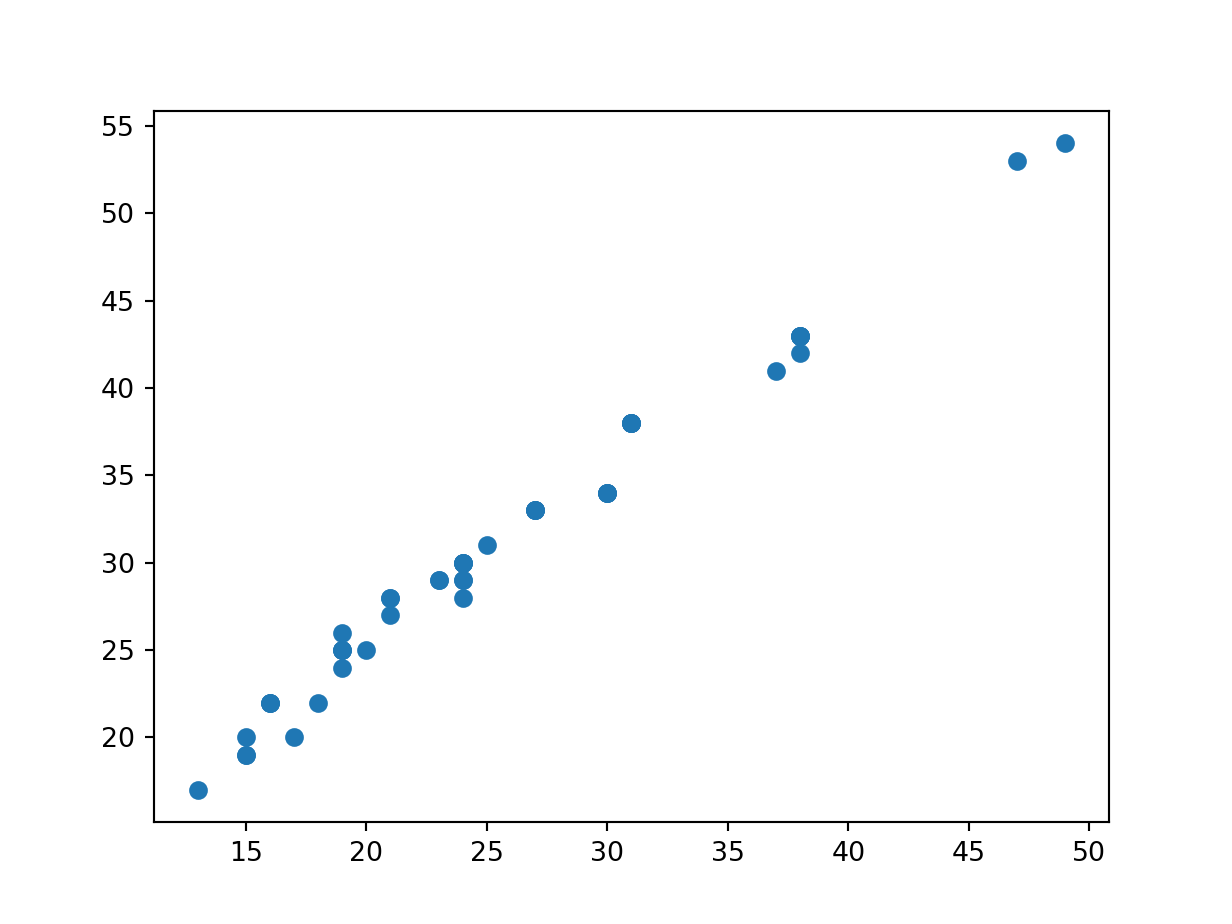

In [12]:
city_mpg, hi_mpg = 23,24
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(d[1:n,city_mpg], d[1:n,hi_mpg])
plt.show()

Now that looks like a line! Let's recall how to fit it!